In [1]:
from keras.datasets import mnist
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import l2_attack
import keras
from defense import *

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Uppercase local vars:
	BATCH_SIZE: 64
	CRITIC_ITERS: 5
	DATA_DIR: cifar-10-batches-py
	DIM: 64
	ITERS: 200000
	LAMBDA: 10
	MODE: wgan-gp
	OUTPUT_DIM: 748


/home/npc/breaking-iclr-2018-defenses/release/defensegan/tflib/plot.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/zmq

In [36]:
xin = tf.placeholder(tf.float32, [30, 128])

session = keras.backend.get_session()
mygan = Generator(30, xin)

keras.backend.set_learning_phase(False)
model = keras.models.load_model("data/mnist")

touse = [x for x in tf.trainable_variables() if 'Generator' in x.name]
saver = tf.train.Saver(touse)
saver.restore(session, 'data/mnist-gan')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = np.array(x_test, dtype=np.float32)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test /= 255.0

# 1. solve the inversion problem                                                                                                                                                               
attack1 = l2_attack.CarliniL2(session, model,
                              lambda x: Generator(30, x),
                              binary_search_steps=1,
                              max_iterations=3000,
                              learning_rate=1e-1,
                              batch_size=30,
                              initial_const=0, targeted=None)

# 2. start there, make it adversarial                                                                                                                                                          
attack2 = l2_attack.CarliniL2(session, model,
                              lambda x: Generator(1, x),
                              binary_search_steps=5,
                              max_iterations=30000,
                              learning_rate=1e-1,
                              batch_size=1,
                              initial_const=1, targeted=False,
                              noise=False, abort_early=False)



INFO:tensorflow:Restoring parameters from data/mnist-gan


True label 7
Preds [1.6938514e-10 1.3955403e-09 2.7626102e-08 6.7454486e-09 1.8495294e-11
 2.6476297e-12 3.8272108e-15 1.0000000e+00 1.4897807e-10 3.1801388e-08]


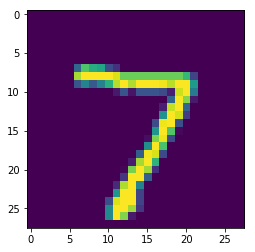

go up to 30
tick 0
0 (2432.6292, 0.0, 2432.6292)
300 (502.9569, 0.0, 502.9569)
600 (349.51617, 0.0, 349.51617)
900 (258.3728, 0.0, 258.3728)
1200 (220.48898, 0.0, 220.48898)
1500 (197.11635, 0.0, 197.11635)
1800 (194.07309, 0.0, 194.07309)
2100 (195.30502, 0.0, 195.30502)
Distortions [1.0220878  0.58228964 0.55365056 0.54344624 0.5649742  0.6303622
 0.5772201  6.4478126  0.49785718 0.47770494 3.5144331  4.0635424
 0.5902556  0.49813095 0.6383693  1.0731678  1.5267377  0.5667313
 0.6503684  0.7180907  3.6054301  0.724195   0.55820054 0.5623124
 0.5928712  0.5313421  7.0777335  6.8217735  0.5583353  1.9701285 ]
[0.47770503]
0.47770503
go up to 1
tick 0
0 (30.579285, 15.625917, 14.953367)
3000 (9.258236, 2.9225073, 6.335729)
6000 (7.9955707, 1.9565449, 6.039026)
9000 (7.799505, 1.7343303, 6.065175)
12000 (7.644734, 1.7233443, 5.9213896)
15000 (7.5863695, 1.7746711, 5.8116984)
18000 (7.45922, 1.1011176, 6.3581023)
21000 (7.966723, 1.2656093, 6.7011137)
24000 (7.3408127, 1.2134784, 6.127334

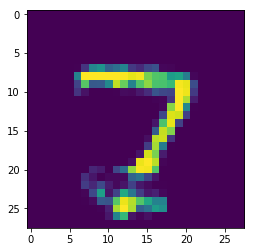

In [37]:
print("True label", y_test[0])
print("Preds",model.predict(x_test)[0])
plt.imshow(x_test[0,:,:,0])
plt.show()

res = attack1.attack([x_test[0]]*30,
                     [np.eye(10)[0]]*30)

start = session.run(attack1.modifier)
it = session.run(mygan, {xin: start})
distortion = np.sum((it-[x_test[0]]*30)**2,(1,2,3))**.5
print("Distortions", distortion)
start = np.array([start[np.argmin(distortion)]])

res = session.run(Generator(1,
                            tf.constant(start, dtype=tf.float32)))
print(np.sum((res-x_test[:1])**2,(1,2,3))**.5)
print(np.mean(np.sum((res-x_test[:1])**2,(1,2,3))**.5))

res = attack2.attack(x_test[:1],
                    [np.eye(10)[q] for q in y_test[:1]],
                    start)

print("L2 Distortion", np.sum((res-x_test[:1])**2)**.5)

print("Preds",model.predict(res)[0])
plt.imshow(res[0,:,:,0])
plt.show()